# CNN Train

### 1.package

In [1]:
import torch
import h5py
import numpy as np
from obspy import read
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import gc

### 2.load data

#### load hdf5

In [2]:

class SeismicDatasetHDF5(Dataset):
    def __init__(self, hdf5_file):
        """初始化并加载HDF5文件中的数据"""
        self.hdf5_file = hdf5_file
        with h5py.File(self.hdf5_file, 'r') as hf:
            self.target_waveforms = hf['target_waveforms'][:]
            self.egfs = hf['egfs'][:]
            self.astfs = hf['astfs'][:]
        
    def __len__(self):
        """返回数据集大小"""
        return len(self.target_waveforms)
    
    def __getitem__(self, idx):
        """返回对应的目标、EGF和ASTF张量"""
        target_waveform = torch.tensor(self.target_waveforms[idx], dtype=torch.float32)
        egf = torch.tensor(self.egfs[idx], dtype=torch.float32)
        astf = torch.tensor(self.astfs[idx], dtype=torch.float32)
        
        return target_waveform, egf, astf

# 使用 DataLoader 加载数据
def get_dataloader_from_hdf5(hdf5_file, batch_size):
    """返回从HDF5文件加载的Dataloader"""
    dataset = SeismicDatasetHDF5(hdf5_file)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
    return dataloader

In [3]:
train_h5 = "/group/data/dataset_ASTF-net/Target_waveforms/Train_pairs.h5"
valid_h5 = "/group/data/dataset_ASTF-net/Target_waveforms/Validation_pairs.h5"
test_level1_h5 = "/group/data/dataset_ASTF-net/Target_waveforms/Test_level1_pairs.h5"
test_level2_h5 = "/group/data/dataset_ASTF-net/Target_waveforms/Test_level2_pairs.h5"
test_level3_h5 = "/group/data/dataset_ASTF-net/Target_waveforms/Test_level3_pairs.h5"

batch_size = 1024

# 加载HDF5数据并创建DataLoader
train_loader = get_dataloader_from_hdf5(train_h5, batch_size)
valid_loader = get_dataloader_from_hdf5(valid_h5, batch_size)
test_level1_loader = get_dataloader_from_hdf5(test_level1_h5, batch_size)
test_level2_loader = get_dataloader_from_hdf5(test_level2_h5, batch_size)
test_level3_loader = get_dataloader_from_hdf5(test_level3_h5, batch_size)

# 查看DataLoader数据
for target_waveforms, egfs, astfs in train_loader:
    print(target_waveforms.shape, egfs.shape, astfs.shape)
    break  # 打印第一批数据的形状

torch.Size([1024, 510]) torch.Size([1024, 510]) torch.Size([1024, 301])


## CNN model

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# class SimpleCNN_MLP(nn.Module):
#     def __init__(self, in_channels=2, seq_len=1024, classes=301):
#         super(SimpleCNN_MLP, self).__init__()
        
#         # CNN 模块
#         self.cnn = nn.Sequential(
#             nn.Conv1d(in_channels, 64, kernel_size=3, padding=1),
#             # nn.BatchNorm1d(64),
#             nn.ReLU(),
#             nn.MaxPool1d(2),  # 降采样
            
#             nn.Conv1d(64, 128, kernel_size=3, padding=1),
#             # nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.MaxPool1d(2)  # 降采样
#         )
        
#         # 自适应平均池化（确保特征维度固定）
#         self.global_pool = nn.AdaptiveAvgPool1d(1)  # 输出大小为 (batch_size, channel, 1)

#         # 全连接模块（MLP）
#         self.mlp = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(128, 128),  # 128 是经过自适应池化后的输出通道数
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(64, classes),  # 输出震源时间函数的维度
#             nn.Softplus()  # 用于确保输出非负
#         )

#     def forward(self, target_waveform, egf):
#         # 将 target_waveform 和 egf 在通道维度拼接 (batch_size, 2, seq_len)
#         x = torch.stack([target_waveform, egf], dim=1)  # 拼接为双通道输入
#         x = self.cnn(x)  # CNN 提取特征
#         x = self.global_pool(x)  # 自适应池化到固定大小
#         x = self.mlp(x)  # 通过 MLP 进行最终预测
#         return x

# class SimpleCNN(nn.Module):
#     def __init__(self, in_channels=2, output_length=301):
#         """
#         一个简单的 CNN 网络，用于反卷积学习任务。
        
#         Args:
#             in_channels (int): 输入的通道数（例如，目标波形和EGF的通道数为2）。
#             output_length (int): 输出序列的长度（例如，震源时间函数的长度）。
#         """
#         super(SimpleCNN, self).__init__()
        
#         # 特征提取模块
#         self.feature_extractor = nn.Sequential(
#             nn.Conv1d(in_channels, 32, kernel_size=3, padding=1),  # 输出通道数 32，卷积核大小 3
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2),  # 池化，序列长度减半

#             nn.Conv1d(32, 64, kernel_size=3, padding=1),  # 输出通道数 64
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2),  # 再次池化，序列长度再减半

#             nn.Conv1d(64, 128, kernel_size=3, padding=1),  # 输出通道数 128
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2)  # 最后一次池化
#         )
        
#         # 全连接模块
#         self.classifier = nn.Sequential(
#             nn.Flatten(),  # 展平特征
#             nn.Linear(8064, 512),  # 假设经过 3 次池化后序列长度减为 output_length // 8
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, output_length),  # 输出为震源时间函数的长度
#             nn.Softplus()  # 用于确保输出非负
#         )
    
#     def forward(self, target_waveform, egf):
#         """
#         前向传播函数。
        
#         Args:
#             target_waveform (torch.Tensor): 目标波形 (batch_size, seq_len)。
#             egf (torch.Tensor): 经验格林函数 (batch_size, seq_len)。

#         Returns:
#             torch.Tensor: 预测的震源时间函数 (batch_size, output_length)。
#         """
#         # 将 target_waveform 和 egf 拼接为 (batch_size, 2, seq_len)
#         x = torch.stack([target_waveform, egf], dim=1)  # 在通道维度拼接
#         x = self.feature_extractor(x)  # 特征提取
#         x = self.classifier(x)  # 全连接分类器
#         return x

# class VGG19(torch.nn.Module):
#     def __init__(self,in_channels=2,classes=301):
#         super(VGG19, self).__init__()
#         self.feature = torch.nn.Sequential(

#             torch.nn.Conv1d(in_channels, 64, kernel_size=3, padding=1),
#             # torch.nn.BatchNorm1d(64),
#             torch.nn.ReLU(),
#             torch.nn.Conv1d(64, 64, kernel_size=3, padding=1),
#             # torch.nn.BatchNorm1d(64),
#             torch.nn.ReLU(),
#             torch.nn.MaxPool1d(2),

#             torch.nn.Conv1d(64, 128, kernel_size=3, padding=1),
#             # torch.nn.BatchNorm1d(128),
#             torch.nn.ReLU(),
#             torch.nn.Conv1d(128, 128, kernel_size=3, padding=1),
#             # torch.nn.BatchNorm1d(128),
#             torch.nn.ReLU(),
#             torch.nn.MaxPool1d(2),

#             torch.nn.Conv1d(128, 256, kernel_size=3, padding=1),
#             # torch.nn.BatchNorm1d(256),
#             torch.nn.ReLU(),
#             torch.nn.Conv1d(256, 256, kernel_size=3, padding=1),
#             # torch.nn.BatchNorm1d(256),
#             torch.nn.ReLU(),
#             torch.nn.Conv1d(256, 256, kernel_size=3, padding=1),
#             # torch.nn.BatchNorm1d(256),
#             torch.nn.ReLU(),
#             torch.nn.Conv1d(256, 256, kernel_size=3, padding=1),
#             # torch.nn.BatchNorm1d(256),
#             torch.nn.ReLU(),
#             torch.nn.MaxPool1d(2),

#             torch.nn.Conv1d(256, 512, kernel_size=3, padding=1),
#             # torch.nn.BatchNorm1d(512),
#             torch.nn.ReLU(),
#             torch.nn.Conv1d(512, 512, kernel_size=3, padding=1),
#             # torch.nn.BatchNorm1d(512),
#             torch.nn.ReLU(),
#             torch.nn.Conv1d(512, 512, kernel_size=3, padding=1),
#             # torch.nn.BatchNorm1d(512),
#             torch.nn.ReLU(),
#             torch.nn.Conv1d(512, 512, kernel_size=3, padding=1),
#             # torch.nn.BatchNorm1d(512),
#             torch.nn.ReLU(),
#             torch.nn.MaxPool1d(2),

#             torch.nn.Conv1d(512, 512, kernel_size=3, padding=1),
#             # torch.nn.BatchNorm1d(512),
#             torch.nn.ReLU(),
#             torch.nn.Conv1d(512, 512, kernel_size=3, padding=1),
#             # torch.nn.BatchNorm1d(512),
#             torch.nn.ReLU(),
#             torch.nn.Conv1d(512, 512, kernel_size=3, padding=1),
#             # torch.nn.BatchNorm1d(512),
#             torch.nn.ReLU(),
#             torch.nn.Conv1d(512, 512, kernel_size=3, padding=1),
#             # torch.nn.BatchNorm1d(512),
#             torch.nn.ReLU(),
#             torch.nn.MaxPool1d(2),

#             torch.nn.AdaptiveAvgPool1d(7)
#         )
#         self.classifer = torch.nn.Sequential(
#             torch.nn.Linear(3584,1024),
#             torch.nn.ReLU(),
#             # torch.nn.Dropout(0.5),
#             torch.nn.Linear(1024,1024),
#             torch.nn.ReLU(),
#             # torch.nn.Dropout(0.5),
#             torch.nn.Linear(1024, 512),
#             torch.nn.ReLU(),
#             torch.nn.Linear(512, classes),
#             torch.nn.Softplus(),
#         )
#         # 添加一个不改变维度的卷积层
#         # self.conv = torch.nn.Conv1d(301, classes, kernel_size=1)
#         # self.relu = torch.nn.ReLU()  # 加入ReLU激活函数
#         # self.sigmoid = torch.nn.Sigmoid()

#     def forward(self, target_waveform, egf):
#         # 将 target_waveform 和 egf 在通道维度拼接 (batch_size, 2, seq_len)
#         x = torch.stack([target_waveform, egf], dim=1)
#         x = self.feature(x)  # 特征提取
#         x = torch.flatten(x, 1)  # 展平
#         x = self.classifer(x)  # 分类器部分
#         return x

class UNet1D(nn.Module):
    def __init__(self, in_channels=2, out_channels=1):
        super(UNet1D, self).__init__()
        # 编码器
        self.encoder1 = nn.Conv1d(in_channels, 64, kernel_size=3, padding=1)
        self.encoder2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.encoder3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.encoder4 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.middle = nn.Conv1d(512, 1024, kernel_size=3, padding=1)

        # 解码器
        self.decoder4 = nn.ConvTranspose1d(1024, 512, kernel_size=2, stride=2)
        self.decoder3 = nn.ConvTranspose1d(512, 256, kernel_size=2, stride=2)
        self.decoder2 = nn.ConvTranspose1d(256, 128, kernel_size=2, stride=2)
        self.decoder1 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)

        self.final = nn.Conv1d(64, out_channels, kernel_size=3, stride=1, padding=1)
        self.softplus = nn.Softplus(beta=1.0, threshold=20.0)

    def forward(self, x):
        # x = torch.cat((target_waveform, egf), dim=1)  # 合并成 [B, 2, L]
        # 编码器
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        middle = self.middle(enc4)

        # 解码器
        dec4 = self.decoder4(middle)[:, :, :enc4.size(2)] + enc4
        dec3 = self.decoder3(dec4)[:, :, :enc3.size(2)] + enc3
        dec2 = self.decoder2(dec3)[:, :, :enc2.size(2)] + enc2
        dec1 = self.decoder1(dec2)[:, :, :enc1.size(2)] + enc1

         # 生成输出并调整尺寸
        output = self.final(dec1)
        
        # 使用插值调整输出尺寸为301
        output_resized = F.interpolate(output, size=301, mode='linear', align_corners=False)
        
        # 应用softplus
        output_softplus = self.softplus(output_resized)
        return output_softplus


# 模型实例化
model = UNet1D()

# 打印模型架构
print(model)


UNet1D(
  (encoder1): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder4): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (middle): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
  (decoder4): ConvTranspose1d(1024, 512, kernel_size=(2,), stride=(2,))
  (decoder3): ConvTranspose1d(512, 256, kernel_size=(2,), stride=(2,))
  (decoder2): ConvTranspose1d(256, 128, kernel_size=(2,), stride=(2,))
  (decoder1): ConvTranspose1d(128, 64, kernel_size=(2,), stride=(2,))
  (final): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (softplus): Softplus(beta=1.0, threshold=20.0)
)


In [31]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)


In [36]:
model = UNet1D()
initialize_weights(model)

# 测试网络输出是否非负
x = torch.randn(2, 1, 510)  # Batch size = 2, channels = 1, input length = 510
output = model(x)
print("Output min value:", output.min().item())
print("Output max value:", output.max().item())



Output min value: 8.596273204375393e-08
Output max value: 16.571279525756836


## Loss Function

#### MAPE（平均绝对百分比误差）

In [5]:
def MAPE_loss(y_pred, y_true):
    """
    计算每个样本的平均绝对百分比误差（MAPE）。
    
    Args:
    y_pred (torch.Tensor): 模型的预测值，形状为 [batch_size, 301]
    y_true (torch.Tensor): 真实值，形状为 [batch_size, 301]
    
    Returns:
    torch.Tensor: 平均 MAPE 损失
    """
    # 计算每个点的绝对百分比误差
    mape = torch.abs((y_pred - y_true) / (y_true + 1e-8))
    
    # 对每个样本计算平均 MAPE
    mean_mape = torch.mean(mape, dim=1)  # [batch_size, 301] -> [batch_size]
    
    # 计算整个批次的平均 MAPE
    loss = torch.mean(mean_mape)  # [batch_size] -> scalar
    
    return loss


#### 加权 MSE

In [5]:
class AmplitudeWeightedMSELoss(nn.Module):
    def __init__(self, epsilon, a):
        super(AmplitudeWeightedMSELoss, self).__init__()
        self.epsilon = epsilon
        self.a = a

    def forward(self, y_pred, y_true):
        # 计算每组数据的振幅范围
        amplitude = torch.max(torch.abs(y_true), dim=1, keepdim=True)[0] + self.epsilon
        
        # 使用振幅范围归一化
        normalized_error = (y_pred - y_true) / amplitude**self.a
        # 计算加权 MSE 损失
        return torch.mean(normalized_error ** 2)


#### 改进加权MSE（在振幅加权 MSE 的基础上，进一步引入对非零数据的额外关注）

In [9]:
class EnhancedAmplitudeWeightedMSELoss(nn.Module):
    def __init__(self, epsilon=1e-6, a=1.0, beta=2.0):
        """
        振幅加权 MSE 损失函数，结合非零数据权重
        Args:
            epsilon (float): 避免振幅为零的偏移量
            a (float): 振幅归一化的指数控制参数
            beta (float): 非零权重因子的放大倍数
        """
        super(EnhancedAmplitudeWeightedMSELoss, self).__init__()
        self.epsilon = epsilon
        self.a = a
        self.beta = beta

    def forward(self, y_pred, y_true):
        # 计算每组数据的振幅范围
        amplitude = torch.max(torch.abs(y_true), dim=1, keepdim=True)[0]
        
        # 避免振幅为零
        amplitude = amplitude + self.epsilon

        # 使用振幅范围归一化误差
        normalized_error = (y_pred - y_true) / amplitude**self.a

        # 构造非零权重
        nonzero_mask = (y_true != 0).float()  # 非零元素的位置为1，零值位置为0
        weights = 1.0 + self.beta * nonzero_mask  # 非零数据的权重为 1 + beta

        # 计算加权 MSE 损失
        weighted_error = weights * (normalized_error ** 2)
        loss = torch.mean(weighted_error)

        return loss


## Train model

In [6]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pth'):
        """
        Args:
            patience (int): 在验证集损失不下降的情况下，允许的最大训练轮数
            verbose (bool): 是否打印早停信息
            delta (float): 判断改进的最小值
            path (str): 保存最佳模型的路径
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')  # 初始化最小验证损失

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:  # 初始化最佳分数
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:  # 检查是否改进
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:  # 如果改进，重置计数器
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """保存当前最佳模型"""
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...")
        torch.save(model.state_dict(), self.path)  # 保存模型
        self.val_loss_min = val_loss


In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# 模型训练函数（加入早停机制）
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device, scheduler=None, patience=10):
    """
    模型训练并加入早停机制
    Args:
        model (nn.Module): 待训练的模型
        train_loader (DataLoader): 训练数据加载器
        val_loader (DataLoader): 验证数据加载器
        num_epochs (int): 训练轮数
        criterion (nn.Module): 损失函数
        optimizer (torch.optim.Optimizer): 优化器
        device (torch.device): 计算设备 (cpu or cuda)
        scheduler (torch.optim.lr_scheduler): 学习率调度器 (可选)
        patience (int): 早停耐心轮数
    """
    print(f"Training on device: {device}")
    model = nn.DataParallel(model).to(device)  # 使用多卡训练

    # 初始化早停参数
    best_val_loss = float("inf")
    best_epoch = 0
    early_stop_counter = 0

    # 用于存储训练和验证损失
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        for target_waveform, egf, astf in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
            # 将数据传输到设备
            target_waveform, egf, astf = target_waveform.to(device), egf.to(device), astf.to(device)

            # 构造 U-Net 的双通道输入
            input_data = torch.cat((target_waveform.unsqueeze(1), egf.unsqueeze(1)), dim=1)  # [B, 2, L]
            
            # 前向传播
            optimizer.zero_grad()
            # predicted_astf = model(target_waveform, egf)  # CNN 模型的双通道输入
            predicted_astf = model(input_data)  # U-Net 双通道输入
            
            # 计算损失
            loss = criterion(predicted_astf, astf)
            train_loss += loss.item()
            
            # 反向传播和优化
            loss.backward()
            optimizer.step()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch {epoch + 1} - Training Loss: {train_loss:.4f}")
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for target_waveform, egf, astf in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
                # 将数据传输到设备
                target_waveform, egf, astf = target_waveform.to(device), egf.to(device), astf.to(device)
                
                # 构造 U-Net 的双通道输入
                input_data = torch.cat((target_waveform.unsqueeze(1), egf.unsqueeze(1)), dim=1)  # [B, 2, L]
                
                # 前向传播
                optimizer.zero_grad()
                # predicted_astf = model(target_waveform, egf)  # CNN 模型的双通道输入
                predicted_astf = model(input_data)  # U-Net 双通道输入
                
                # 计算损失
                loss = criterion(predicted_astf, astf)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch + 1} - Validation Loss: {val_loss:.4f}")
        
        # 调用学习率调度器
        if scheduler:
            scheduler.step(val_loss)  # 使用验证集损失来调整学习率
        
        # 打印当前学习率
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch + 1} - Current Learning Rate: {current_lr:.6f}")
        
        # 保存最优模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            early_stop_counter = 0  # 重置早停计数器
            torch.save(model.state_dict(), "best_seismic_Unet_AmpWeiMSE_1.pth")
            print(f"Model saved with Validation Loss: {best_val_loss:.4f}")
        else:
            early_stop_counter += 1
            print(f"EarlyStopping counter: {early_stop_counter} out of {patience}")
        
        # 检查早停条件
        if early_stop_counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break

    print(f"Training completed. Best model achieved at epoch {best_epoch} with Validation Loss: {best_val_loss:.4f}")
    return train_losses, val_losses


# 可视化训练和验证损失
def visualize_loss(train_losses, val_losses):
    """
    可视化训练和验证损失
    Args:
        train_losses (list): 每个epoch的训练损失
        val_losses (list): 每个epoch的验证损失
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss", marker='o')
    plt.plot(val_losses, label="Validation Loss", marker='x')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


#### K折交叉验证

In [ ]:
from sklearn.model_selection import KFold

def train_with_kfold(model, dataset, num_epochs, criterion, optimizer, device, k_folds=5, scheduler=None):
    """
    使用 K 折交叉验证训练模型

    Args:
        model (nn.Module): 待训练的模型
        dataset (Dataset): 数据集
        num_epochs (int): 训练轮数
        criterion (nn.Module): 损失函数
        optimizer (torch.optim.Optimizer): 优化器
        device (torch.device): 计算设备 (cpu or cuda)
        k_folds (int): 折数 (默认5)
        scheduler (torch.optim.lr_scheduler): 学习率调度器 (可选)
    """
    print(f"Training on device: {device} with {k_folds}-Fold Cross Validation")
    kfold = KFold(n_splits=k_folds, shuffle=True)
    
    fold_results = {}  # 存储每一折的验证结果
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}/{k_folds}")
        
        # 获取当前折的训练和验证数据
        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
        
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=train_sampler)
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=val_sampler)
        
        # 初始化模型（重新设置权重）
        model.apply(reset_weights)  # 保证每一折都是独立训练的
        
        # 训练和验证
        best_val_loss = float("inf")
        train_losses = []
        val_losses = []
        
        for epoch in range(num_epochs):
            # 训练阶段
            model.train()
            train_loss = 0.0
            for target_waveform, egf, astf in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
                target_waveform, egf, astf = target_waveform.to(device), egf.to(device), astf.to(device)
                
                optimizer.zero_grad()
                predicted_astf = model(target_waveform, egf)
                loss = criterion(predicted_astf, astf)
                train_loss += loss.item()
                loss.backward()
                optimizer.step()
            
            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            
            # 验证阶段
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for target_waveform, egf, astf in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
                    target_waveform, egf, astf = target_waveform.to(device), egf.to(device), astf.to(device)
                    predicted_astf = model(target_waveform, egf)
                    loss = criterion(predicted_astf, astf)
                    val_loss += loss.item()
            
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            
            print(f"Epoch {epoch + 1} - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
            
            # 调用学习率调度器
            if scheduler:
                scheduler.step(val_loss)
            
            # 保存最优模型
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f"best_model_fold_{fold + 1}.pth")
                print(f"Model saved for Fold {fold + 1} with Validation Loss: {best_val_loss}")
        
        # 保存当前折的验证结果
        fold_results[fold] = {"train_losses": train_losses, "val_losses": val_losses}
        
        # 打印当前折结果
        print(f"Fold {fold + 1} - Best Validation Loss: {best_val_loss}")
    
    # 打印总体结果
    print("\nK-Fold Cross Validation Results:")
    total_val_loss = 0.0
    for fold, result in fold_results.items():
        val_loss = min(result["val_losses"])
        print(f"Fold {fold + 1} - Best Validation Loss: {val_loss:.4f}")
        total_val_loss += val_loss
    print(f"Average Validation Loss: {total_val_loss / k_folds:.4f}")

    return fold_results

def reset_weights(m):
    """
    重置模型权重，用于每折交叉验证时初始化模型
    """
    if isinstance(m, (torch.nn.Conv1d, torch.nn.Linear)):
        m.reset_parameters()



In [ ]:
# 参数和超参数设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-3
num_epochs = 200
# weight_decay = 1e-5

# 使用之前完成的数据加载

# 初始化模型
# model = VGG19(in_channels=2, classes=301)# 初始化模型
model = UNet1D(in_channels=2, out_channels=1)

criterion = AmplitudeWeightedMSELoss(epsilon=1e-6, a=0.8)  # 使用自定义的相对均方误差损失
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# 训练模型
train_losses, val_losses = train_model(model, train_loader, valid_loader, num_epochs, criterion, optimizer, device, scheduler, patience=20)

visualize_loss(train_losses, val_losses)

# # 执行 K 折交叉验证
# k_folds = 5
# num_epochs = 20
# fold_results = train_with_kfold(model, dataset, num_epochs, criterion, optimizer, device, k_folds=k_folds, scheduler=scheduler)


Training on device: cuda


Epoch 1/200 - Training: 100%|██████████| 13829/13829 [1:08:40<00:00,  3.36it/s]


Epoch 1 - Training Loss: 3.0234


Epoch 1/200 - Validation: 100%|██████████| 1085/1085 [02:23<00:00,  7.55it/s]


Epoch 1 - Validation Loss: 0.8647
Epoch 1 - Current Learning Rate: 0.001000
Model saved with Validation Loss: 0.8647


Epoch 2/200 - Training: 100%|██████████| 13829/13829 [1:08:52<00:00,  3.35it/s]


Epoch 2 - Training Loss: 0.8559


Epoch 2/200 - Validation: 100%|██████████| 1085/1085 [02:24<00:00,  7.49it/s]


Epoch 2 - Validation Loss: 0.8647
Epoch 2 - Current Learning Rate: 0.001000
Model saved with Validation Loss: 0.8647


Epoch 3/200 - Training: 100%|██████████| 13829/13829 [1:08:59<00:00,  3.34it/s]


Epoch 3 - Training Loss: 0.8559


Epoch 3/200 - Validation: 100%|██████████| 1085/1085 [02:27<00:00,  7.37it/s]


Epoch 3 - Validation Loss: 0.8648
Epoch 3 - Current Learning Rate: 0.001000
EarlyStopping counter: 1 out of 20


Epoch 4/200 - Training: 100%|██████████| 13829/13829 [1:09:07<00:00,  3.33it/s]


Epoch 4 - Training Loss: 0.8559


Epoch 4/200 - Validation: 100%|██████████| 1085/1085 [02:24<00:00,  7.49it/s]


Epoch 4 - Validation Loss: 0.8648
Epoch 4 - Current Learning Rate: 0.001000
EarlyStopping counter: 2 out of 20


Epoch 5/200 - Training: 100%|██████████| 13829/13829 [1:08:56<00:00,  3.34it/s]


Epoch 5 - Training Loss: 0.8559


Epoch 5/200 - Validation: 100%|██████████| 1085/1085 [02:24<00:00,  7.49it/s]


Epoch 5 - Validation Loss: 0.8648
Epoch 5 - Current Learning Rate: 0.001000
EarlyStopping counter: 3 out of 20


Epoch 6/200 - Training: 100%|██████████| 13829/13829 [1:09:03<00:00,  3.34it/s]


Epoch 6 - Training Loss: 0.8559


Epoch 6/200 - Validation: 100%|██████████| 1085/1085 [02:25<00:00,  7.45it/s]


Epoch 6 - Validation Loss: 0.8647
Epoch 6 - Current Learning Rate: 0.001000
EarlyStopping counter: 4 out of 20


Epoch 7/200 - Training: 100%|██████████| 13829/13829 [1:08:56<00:00,  3.34it/s]


Epoch 7 - Training Loss: 0.8559


Epoch 7/200 - Validation: 100%|██████████| 1085/1085 [02:23<00:00,  7.56it/s]


Epoch 7 - Validation Loss: 0.8648
Epoch 7 - Current Learning Rate: 0.001000
EarlyStopping counter: 5 out of 20


Epoch 8/200 - Training: 100%|██████████| 13829/13829 [1:08:52<00:00,  3.35it/s]


Epoch 8 - Training Loss: 0.8559


Epoch 8/200 - Validation: 100%|██████████| 1085/1085 [02:25<00:00,  7.48it/s]


Epoch 8 - Validation Loss: 0.8648
Epoch 8 - Current Learning Rate: 0.001000
EarlyStopping counter: 6 out of 20


Epoch 9/200 - Training: 100%|██████████| 13829/13829 [1:09:05<00:00,  3.34it/s]


Epoch 9 - Training Loss: 0.8559


Epoch 9/200 - Validation: 100%|██████████| 1085/1085 [02:26<00:00,  7.43it/s]


Epoch 9 - Validation Loss: 0.8648
Epoch 9 - Current Learning Rate: 0.001000
EarlyStopping counter: 7 out of 20


Epoch 10/200 - Training:   0%|          | 0/13829 [00:00<?, ?it/s]

In [9]:
torch.cuda.empty_cache()

### Test model

In [11]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

def test_model(model, test_loader, criterion, device):
    """
    测试模型并评估性能，输出测试损失并可视化预测结果
    Args:
        model (nn.Module): 已训练好的模型
        test_loader (DataLoader): 测试数据加载器
        criterion (nn.Module): 损失函数
        device (torch.device): 计算设备 (cpu or cuda)
    """
    model.eval()  # 设置模型为评估模式
    model = model.to(device)
    
    test_loss = 0.0
    all_predicted = []
    all_actual = []
    
    with torch.no_grad():
        for target_waveform, egf, astf in tqdm(test_loader, desc="Testing"):
            target_waveform, egf, astf = target_waveform.to(device), egf.to(device), astf.to(device)
            
            # 模型预测
            predicted_astf = model(target_waveform, egf)
            
            # 计算损失
            loss = criterion(predicted_astf, astf)
            test_loss += loss.item()
            
            # 保存预测值和真实值以便后续分析
            all_predicted.append(predicted_astf.cpu())
            all_actual.append(astf.cpu())
    
    # 计算平均测试损失
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    
    return all_predicted, all_actual
    # 可视化部分预测结果
    # visualize_predictions(all_predicted, all_actual, num_samples=20)


def visualize_predictions_one_batch(predicted, actual, batch_index, num_samples, test_name):
    """
    Visualize the predictions vs. actual values for one specific batch.

    Args:
        predicted (list or torch.Tensor): Predicted values (list of tensors or arrays, or tensor of shape [num_batches, batch_size, time_steps]).
        actual (list or torch.Tensor): Actual values (list of tensors or arrays, or tensor of shape [num_batches, batch_size, time_steps]).
        batch_index (int): Index of the batch to visualize (default: 0, the first batch).
        num_samples (int): Number of samples to plot within the selected batch (default: 10).
    """
    # 如果输入是列表，将其转换为 NumPy 数组以便统一处理
    if isinstance(predicted, list):
        predicted = np.array([p.cpu().numpy() if hasattr(p, 'cpu') else p for p in predicted])
    if isinstance(actual, list):
        actual = np.array([a.cpu().numpy() if hasattr(a, 'cpu') else a for a in actual])

    # 检查 batch_index 是否有效
    if batch_index >= len(predicted):
        raise ValueError(f"Invalid batch_index {batch_index}. Total batches: {len(predicted)}.")

    # 获取指定 batch 的预测值和真实值
    predicted_batch = predicted[batch_index]
    actual_batch = actual[batch_index]

    # 确保绘图样本数量不超过该 batch 的大小
    num_samples = min(num_samples, len(predicted_batch))

    plt.figure(figsize=(12, 6))

    for i in range(num_samples):
        # 对每个样本进行归一化
        pred_norm = (predicted_batch[i] - np.min(predicted_batch[i])) / (np.max(predicted_batch[i]) - np.min(predicted_batch[i]))
        actual_norm = (actual_batch[i] - np.min(actual_batch[i])) / (np.max(actual_batch[i]) - np.min(actual_batch[i]))

        # 添加垂直偏移量以避免曲线重叠
        vertical_offset = i * 1.5  # 每条曲线之间的间隔
        plt.plot(actual_norm + vertical_offset, color='blue', alpha=0.6)  # 真实值
        plt.plot(pred_norm + vertical_offset, linestyle='dashed', color='red', alpha=0.6)  # 预测值

    # 添加图例，只标记一次
    plt.plot([], [], color='blue', label="Actual")
    plt.plot([], [], linestyle='dashed', color='red', label="Predicted")

    plt.title(f"{test_name} Predictions vs. Actuals for {num_samples} Samples", fontsize=20)
    plt.xlabel("Time Steps", fontsize=15)
    plt.ylabel("Number", fontsize=15)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [71]:
# 模型、损失函数和优化器
# 初始化模型
model = SimpleCNN(in_channels=2, output_length=301)# 初始化模型
model = nn.DataParallel(model)

# 加载模型权重
state_dict = torch.load("best_seismic_cnn_model_AmpWeiMSE_2.pth")
model.load_state_dict(state_dict)

# 测试数据加载器 (test_level1_loader)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = AmplitudeWeightedMSELoss(epsilon=1e-6, a=0.8)  # 替换为你定义的损失函数

# 调用测试函数
all_predicted, all_actual=test_model(model, test_level3_loader, criterion, device)


/tmp/ipykernel_4865/2087674527.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("best_seismic_cnn_model_AmpWeiMSE_2.pth")
Testing: 100%|██████████

Test Loss: 0.5159


/tmp/ipykernel_4865/714528573.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predicted = np.array([p.cpu().numpy() if hasattr(p, 'cpu') else p for p in predicted])
/tmp/ipykernel_4865/714528573.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actual = np.array([a.cpu().numpy() if hasattr(a, 'cpu') else a for a in actual])


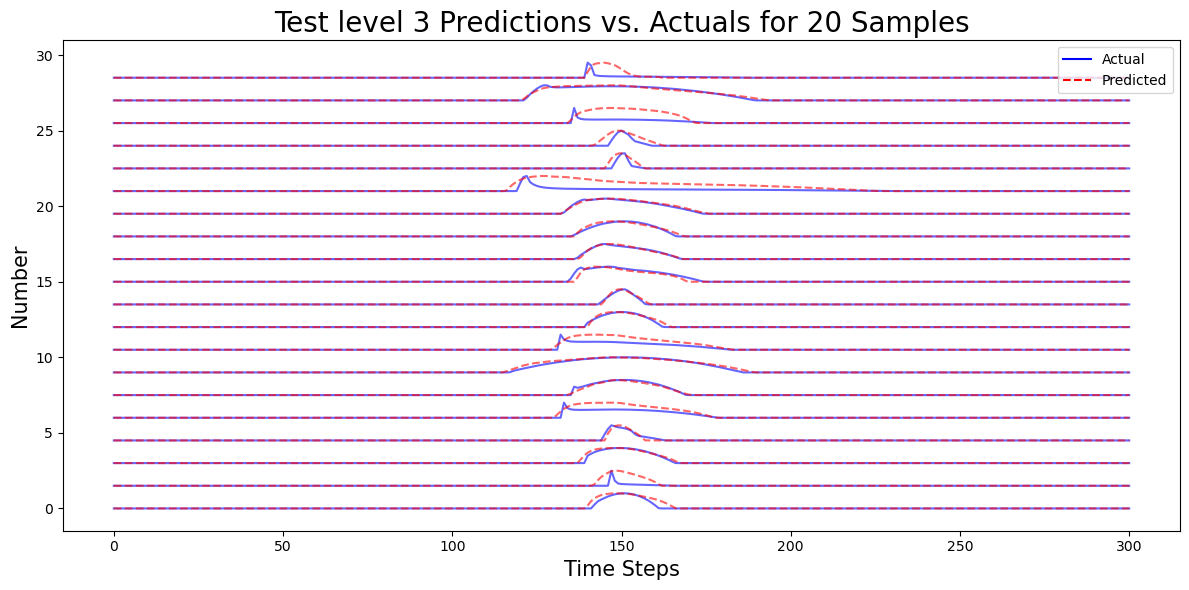

In [73]:
visualize_predictions_one_batch(all_predicted, all_actual, batch_index=0, num_samples=20, test_name = "Test level 3")

#### CC

In [75]:
def compute_and_plot_cc_all_samples(predicted, actual, test_name):
    """
    计算所有样本的预测值和真实值之间的相关系数 (CC)，绘制分布图，并计算 CC > 0.9 的比例。

    参数:
        predicted (list of torch.Tensor): 预测值，每个元素为一个 batch 的张量。
        actual (list of torch.Tensor): 真实值，每个元素为一个 batch 的张量。
    """
    # 确保输入是列表
    assert isinstance(predicted, list) and isinstance(actual, list), "预测值和真实值应为包含多个 batch 的列表！"
    assert len(predicted) == len(actual), "预测值和真实值的 batch 数量必须相同！"

    # 保存所有样本的 CC 值
    all_cc_values = []

    # 遍历每个 batch
    for batch_idx in range(len(predicted)):
        # 获取当前 batch 的数据
        batch_predicted = predicted[batch_idx]
        batch_actual = actual[batch_idx]

        # 确保张量是 NumPy 数组
        if isinstance(batch_predicted, torch.Tensor):
            batch_predicted = batch_predicted.detach().cpu().numpy()
        if isinstance(batch_actual, torch.Tensor):
            batch_actual = batch_actual.detach().cpu().numpy()

        # 检查形状
        assert batch_predicted.shape == batch_actual.shape, "预测值和真实值的形状必须相同！"

        # 计算每对信号的相关系数 (CC)
        for i in range(batch_predicted.shape[0]):  # 遍历 batch 中的每个样本
            cc = np.corrcoef(batch_predicted[i], batch_actual[i])[0, 1]  # 取相关系数矩阵的 [0, 1] 元素
            all_cc_values.append(cc)

    # 转换为 NumPy 数组
    all_cc_values = np.array(all_cc_values)

    # 计算 CC > 0.9 的比例
    cc_greater_than_09 = np.sum(all_cc_values > 0.9) / len(all_cc_values)

    # 可视化 CC 值分布
    plt.figure(figsize=(12, 8))
    plt.hist(
        all_cc_values,
        bins=50,
        alpha=0.75,
        edgecolor="black",
        color="blue"
    )
    # plt.axvline(x=0.9, color="red", linestyle="--", label="CC = 0.9")
    plt.axvline(x=np.mean(all_cc_values), color="green", linestyle="--", label=f"Mean CC = {np.mean(all_cc_values):.2f}")
    plt.title(f"{test_name} CC Distribution", fontsize=20)
    plt.xlabel("Correlation Coefficient (CC)", fontsize=15)
    plt.ylabel("Frequency", fontsize=15)
    plt.legend()
    plt.grid(True)

    # 设置轴范围为 0 到 1
    plt.xlim(0.4, 1)
    
    # 在图上标注 PCC > 0.9 的比例
    text_x = 0.42  # 文本位置 (x 坐标)
    text_y = plt.gca().get_ylim()[1] * 0.85  # 文本位置 (y 坐标)
    plt.text(
        text_x, text_y, 
        f"CC > 0.9: {cc_greater_than_09:.2%}", 
        fontsize=15, 
        color="black", 
        # bbox=dict(facecolor='white', alpha=0.8, edgecolor='red')
    )
    plt.show()

    # 打印结果
    print(f"Total samples: {len(all_cc_values)}")
    print(f"Proportion of CC > 0.9: {cc_greater_than_09:.2%}")

    # 返回 CC 值和 CC > 0.9 的比例
    return all_cc_values, cc_greater_than_09


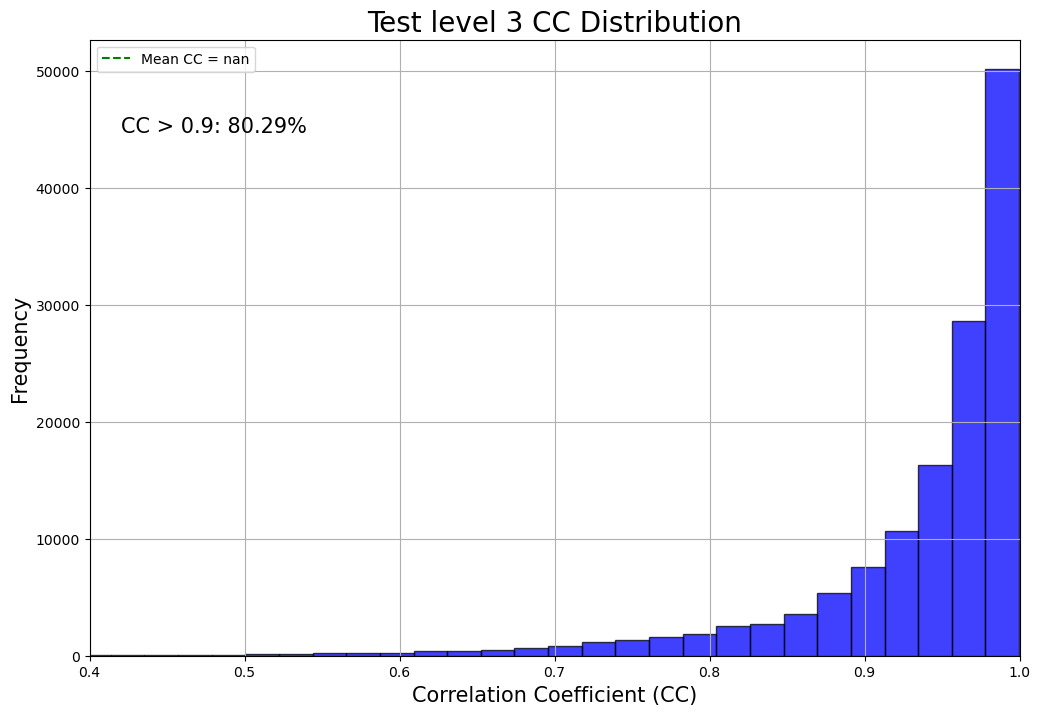

Total samples: 137666
Proportion of CC > 0.9: 80.29%


In [76]:
# 计算并绘制所有样本的 CC 值分布
all_cc_values, cc_greater_than_09 = compute_and_plot_cc_all_samples(all_predicted, all_actual, test_name = "Test level 3")


In [77]:
np.mean(all_cc_values)

nan

#### ASTF Durations

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib.colors import LogNorm


In [81]:
def Tau_c(ASTF, delta):  
    """
    计算表观特征持续时间 Tau_c。
    Args:
        ASTF (ndarray): 表观震源时间函数。
        delta (float): 采样时间间隔。

    Returns:
        float: 计算得到的 Tau_c，如果输入为全零，则返回 0。
    """
    if np.any(np.isnan(ASTF)) or np.any(np.isinf(ASTF)):
        raise ValueError("Input ASTF contains NaN or Inf values.")
    
    if np.all(ASTF == 0):
        return 0  # 如果 ASTF 全为 0，直接返回 0
    
    ASTF_int = np.zeros(len(ASTF))
    tt = np.arange(0, delta * len(ASTF), delta)

    for i in range(1, len(ASTF)):
        ASTF_int[i] = ASTF_int[i - 1] + (ASTF[i - 1] + ASTF[i]) / 2
    ASTF_int *= delta

    if ASTF_int[-1] == 0:
        return 0  # 如果归一化分母为 0，返回 0
    
    ASTF = ASTF / (ASTF_int[-1] + 1e-10)  # 避免除以零
    temp1 = tt * ASTF
    temp2 = tt**2 * ASTF

    miu = np.zeros(len(ASTF))
    miu2 = np.zeros(len(ASTF))
    for i in range(1, len(ASTF)):
        miu[i] = miu[i - 1] + (temp1[i - 1] + temp1[i]) / 2
        miu2[i] = miu2[i - 1] + (temp2[i - 1] + temp2[i]) / 2
    miu *= delta
    miu2 *= delta

    variance = miu2[-1] - miu[-1] ** 2
    if variance < 0:
        variance = 0  # 避免负值
    return 2 * np.sqrt(variance)


def compute_durations(all_data, delta):
    """
    计算所有批次的 Tau_c。
    Args:
        all_data (list of tensors): 包含多个批次的预测或真实值。
        delta (float): 采样时间间隔。

    Returns:
        ndarray: 每个数据的 Tau_c。
    """
    durations = []
    for batch in all_data:
        for trace in batch:
            # 将 PyTorch Tensor 转换为 NumPy 数组
            trace_np = trace.numpy()
            durations.append(Tau_c(trace_np, delta))
    return np.array(durations)


# 计算预测和真实值的特征持续时间
delta = 0.01
actual_durations = compute_durations(all_actual, delta)
predicted_durations = compute_durations(all_predicted, delta)

# # 将 NaN 值替换为 0
# actual_durations = np.nan_to_num(actual_durations)
# predicted_durations = np.nan_to_num(predicted_durations)


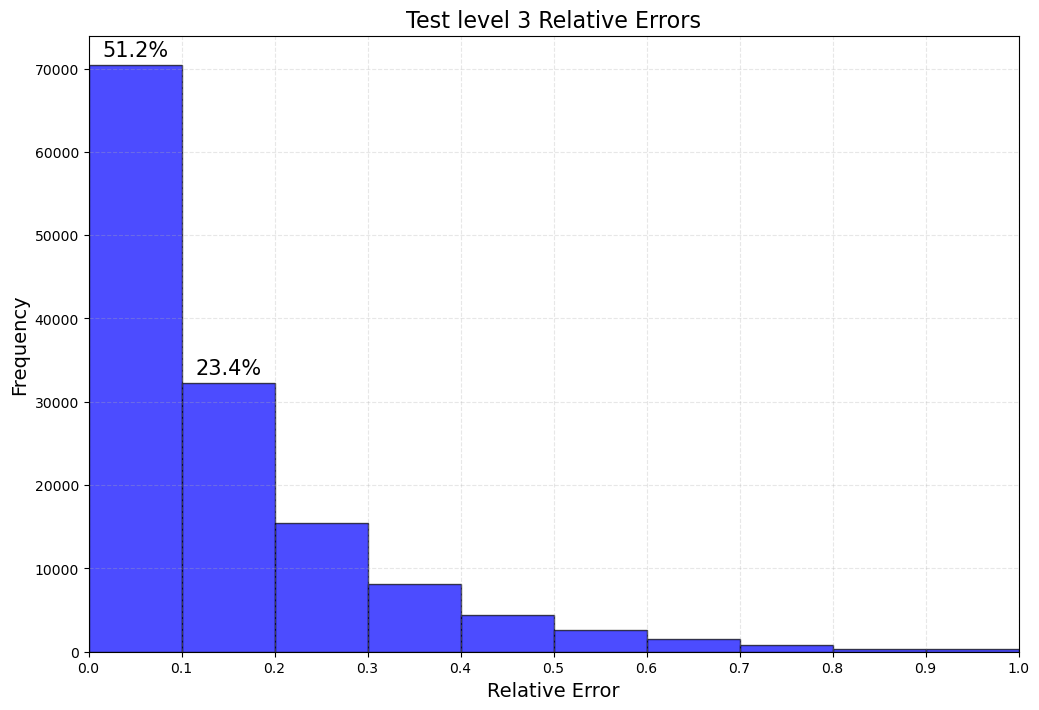

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# 计算相对误差：|actual - predicted| / actual
relative_errors = np.abs(actual_durations - predicted_durations) / actual_durations

# 设置分箱边界（0.1 一个箱）
bins = np.arange(0, 1.1, 0.1)  # 从 0 到 1，以 0.1 为间隔

# 绘制直方图
plt.figure(figsize=(12, 8))
counts, _, _ = plt.hist(relative_errors, bins=bins, color='blue', alpha=0.7, edgecolor='black', rwidth=1)

# 计算每个箱的百分比
percentages = counts / len(relative_errors) * 100  # 计算每个箱的频率占比

percentage_within_10 = (relative_errors <= 0.1).sum() / len(relative_errors) * 100  # 百分比

# 标记 0.1、0.2、0.3 三个箱的百分比
highlight_bins = [0.1, 0.2]  # 需要标记的箱
for bin_value in highlight_bins:
    bin_index = int(bin_value / 0.1)  # 找到对应箱的索引
    percentage = percentages[bin_index - 1]  # 获取该箱的百分比
    plt.text(bin_value - 0.05, counts[bin_index - 1] + 1000,  # 在柱子顶部稍微偏上
             f'{percentage:.1f}%', fontsize=15, color='black', ha='center')

# 图形设置
plt.title("Test level 3 Relative Errors", fontsize=16)
plt.xlabel("Relative Error", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim(0, 1)
plt.xticks(bins)  # 显示箱边界值
plt.grid(True, linestyle="--", alpha=0.3)
# plt.grid(True)

# 显示图像
plt.show()

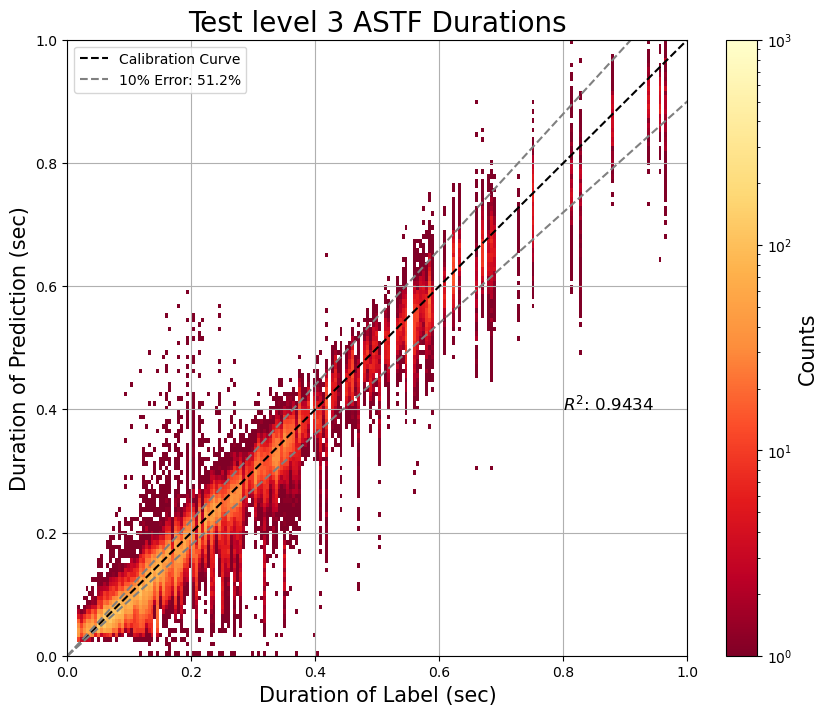

In [83]:

# 绘制预测值与真实值的对比图
plt.figure(figsize=(10, 8))
# 计算 2D 直方图
bins = 200
hist, xedges, yedges = np.histogram2d(
    actual_durations, predicted_durations, bins=bins, density=True
)

# 使用 pcolormesh 绘制
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
plt.pcolormesh(xedges, yedges, hist.T, norm=LogNorm(vmin=1, vmax=1e3), cmap="YlOrRd_r")

# 添加 colorbar
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts', fontsize=15)

# 添加校准曲线
max_duration = max(actual_durations.max(), predicted_durations.max())
plt.plot([0, max_duration], [0, max_duration], 'k--', label='Calibration Curve')

# 添加 10% 相对误差线（灰色）
plt.plot([0, max_duration], [0, max_duration * 1.1], color='gray', linestyle='--', label=f"10% Error: {percentage_within_10:.1f}%")
plt.plot([0, max_duration], [0, max_duration * 0.9], color='gray', linestyle='--')

# 设置轴范围为 0 到 1
plt.xlim(0, 1)
plt.ylim(0, 1)

# 计算 R^2
r2 = r2_score(actual_durations, predicted_durations)
plt.text(0.8, 0.4, f'$R^2$: {r2:.4f}', fontsize=12, color='black')

plt.xlabel('Duration of Label (sec)',fontsize=15)
plt.ylabel('Duration of Prediction (sec)', fontsize=15)
plt.title('Test level 3 ASTF Durations', fontsize=20)
plt.legend()
plt.grid()
plt.show()

